In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.style.use("fivethirtyeight")

from sklearn.model_selection import train_test_split

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from tqdm.notebook import trange

from utils import get_label, evaluate, Imputer, Vectorizer, Splitter

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
data = pd.read_csv("data/train.tsv", sep="\t")
x_all, y_all = data.drop("label", axis=1), get_label(data)
x_train, x_test, y_train, y_test = train_test_split(data.drop("label", axis=1), get_label(data), random_state=RANDOM_SEED)
print("1s in a dataset: {:.2f}%".format(y_train.mean()*100))
x_train.head()

1s in a dataset: 8.05%


,statement,subject,speaker,speaker_job,state,party,context
10148,Nearly 65 percent -- almost two-thirds -- of a...,immigration,jeb-bush,NaN,Florida,republican,in his book 'Immigration Wars'
6904,"Says that except for foreign policy, Ron Pauls...",voting-record,paul-broun,Congressman,Georgia,republican,a fundraiser letter
1721,Ronald Reagan banned ownership of fully automa...,"guns,history",alfonso-lopez,State delegate,Virginia,democrat,a floor speech.
5466,Americans now support strikes (against ISIS) b...,"polls,terrorism",katrina-vanden-heuvel,NaN,NaN,none,"a panel on ABC's ""This Week"""
6794,"Amendment 2 will put almost 2,000 pot shops in...","florida-amendments,marijuana",vote-no-2,NaN,Florida,none,a video


In [3]:
impute_vectorize = Pipeline([
    ("imputer", Imputer), ("vectorizer", Vectorizer)
])

split_vectorize = Pipeline([
    ("splitter", Splitter), ("vectorizer", Vectorizer)
])

column_transformer = ColumnTransformer([
       ("statement_vectorizer", Vectorizer ,"statement"),
        ("subject_vectorizer", split_vectorize, "subject"),
        ("job", impute_vectorize, "speaker_job"),
        ("state", impute_vectorize, "state"),
        ("party", impute_vectorize, "party"),
        ("context", impute_vectorize, "context")
    ])


pipeline = Pipeline([
    ("get_features", column_transformer),
    ("predict", LogisticRegression(max_iter=1000, tol=1e-6, C=0.64))
])

Accuracy: 91.51
F-1 score: 0.0840


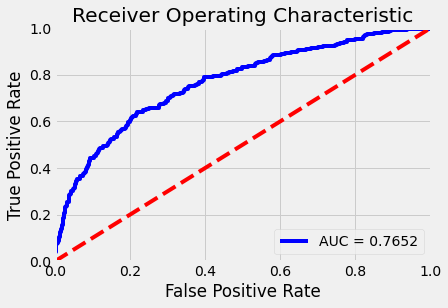

0.7651664457634606

In [4]:
pipeline.fit(x_train, y_train)
evaluate(pipeline, x_test, y_test)

In [5]:
scores = cross_val_score(pipeline, x_all, y_all, scoring="roc_auc", cv=100)
print("{:.4f} +/- {:.4f}".format(np.mean(scores), np.std(scores)))

0.7509 +/- 0.0914


In [6]:
scores = []
for rs in trange(100):
    x_train, x_test, y_train, y_test = train_test_split(data.drop("label", axis=1), get_label(data), random_state=rs)
    pipeline.fit(x_train, y_train)
    roc_auc = evaluate(pipeline, x_test, y_test, verbose=False)
    scores.append(roc_auc)

In [9]:
print("{:.4f} +/- {:.4f}".format(np.mean(scores), np.std(scores)))

0.7408 +/- 0.0165
